In [1]:
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams
plt.rcParams['xtick.labelsize']  = 18
plt.rcParams['ytick.labelsize']  = 18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family']      = 'STIXGeneral'
plt.rcParams['axes.labelsize']   = 20
plt.rcParams['axes.titlesize']   = 20
plt.rcParams['font.size']        = 10
plt.rcParams['legend.fontsize']  = 20
plt.rcParams.update({'figure.autolayout': True})
#import scienceplots
#plt.style.use(['science','ieee'])

from tqdm import tqdm
import random
import os
import time
import h5py
from datetime import datetime


import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2DTranspose

# Import auxiliary libraries

import auxLib; importlib.reload(auxLib)

Importing library...
Library successfully imported
Importing library...
Library successfully imported


<module 'auxLib' from 'd:\\Facultad\\Doctorado\\Proyectos\\paper\\auxLib.py'>

# Main variables

In [2]:
L = 40

densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

densities_str = ['055','06', '061', '062', '063', '064', '065', '07', '08', '09','1']

first_neurons = [i for i in range(1,11)]
middle_neurons = [20 * i for i in range(1,6)]
last_neurons = [50 * i for i in range(3,21)]

neurons = first_neurons + middle_neurons + last_neurons

seed = 15

callbacks = auxLib.myCallback() # to be able to stop training if accuracy is high enough

In [3]:
# Setting the directories

training = 'all'

modelsfolder, resultsfolder = auxLib.folders(directory=None, training=[training]) #If None, a new folder named as today's date will be created 

# Synthetic data

In [29]:
# Initialize the synthetic image generator

data = auxLib.SyntheticImagesGen(training=['all'], L=L)

# Generate synthetic data

train_images, train_labels = data.dataGenerator(10000)
test_images, test_labels = data.dataGenerator(1000)

train_images = train_images.reshape((10000, L * L))
test_images = test_images.reshape((1000, L * L))

Generating synthetic data...
Done!
Elapsed time: 0.34490180015563965 seconds
Generating synthetic data...
Done!
Elapsed time: 0.029636144638061523 seconds


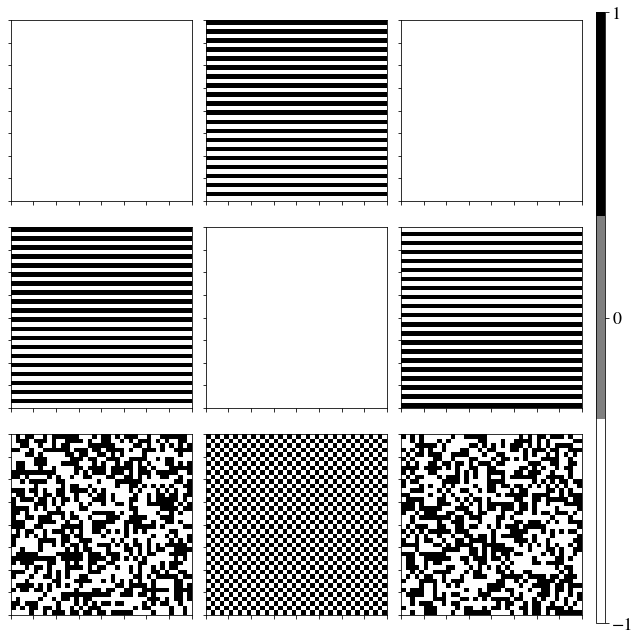

In [30]:
# Random graphs to show how to plot them

lattices_to_graph = [train_images[10 * i].reshape((L, L)) for i in range(9)]

auxLib.latticeGraph(lattices_to_graph, L)

# Training of Neural Network

In [ ]:
# Generate DNN models

for neuron in tqdm(neurons, desc=f"Generating DNN models", unit="neuron"):
    np.random.seed(seed)
    if neuron==1 or neuron==2:
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    else:   
        kernel_regularizer=tf.keras.regularizers.l2(0.01)

    dnn = auxLib.DenseNeuralNetworkGen() # Initializing. It generates the model

    dnn.build_model((L*L,), num_classes=4, layers=[
    {'type': 'dense', 'units': neuron, 'activation': 'relu', 'kernel_regularizer': kernel_regularizer},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 4, 'activation': 'softmax'}
    ])

    dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dnn.summary()

    dnn.fit(train_images, train_labels, 
            epochs=50, batch_size=20,
            validation_data=(test_images, test_labels), 
            callbacks=[callbacks],
            verbose=False)
    
    dnn.save_weights(f'dnn_n{neuron}_DO02', directory=modelsfolder) # name of the model (exclude the 'weights' and the extension)
    dnn.save_model(f'dnn_n{neuron}_DO02', directory=modelsfolder)

# How to load a model

In [32]:
# Initialize the DenseNeuralNetworkGen instance
dnn = auxLib.DenseNeuralNetworkGen()

training = 'all'
# Load the model
dnn.load_model(f'dnn_n2_DO02', directory=modelsfolder)

# Load the weights
dnn.load_weights(f'dnn_n2_DO02', directory=modelsfolder)  # Load the weights directly on the same instance

Model "dnn_all_n2_DO02" correctly loaded from d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n2_DO02.h5
Weights of the model "dnn_all_n2_DO02" correctly loaded from d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n2_DO02_weights.h5


# Loading simulated images to test the NN

In [33]:
# Initializing loader and saver

loader_init = auxLib.loader_and_saver(os.getcwd())

# Loading simulated images

sim_images, temperature = loader_init.simulatedImages(-1)


Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:02<00:00, 63.53array/s]

Files loaded!
Data of density p = 1. succesfully loaded.


# Predictions

In [ ]:
training = 'all'

for neuron in neurons:
    index = neurons.index(neuron)

    model_path = os.path.join(modelsfolder, f'dnn_n{neuron}_DO02.h5')

    dnn = keras.models.load_model(model_path)

    prediction = auxLib.predictor(L, dnn, sim_images, neuron, 
                                training=['para', 'ferro', 'neel', 'stripe'],
                                directory=resultsfolder, 
                                reshape = True, 
                                verbose=False, 
                                save_prediction=True)


# Calculating critical temperature

In [ ]:
critical_temperatures = []

for neuron in neurons:
    prediction = pd.read_csv(resultsfolder+f'/predictions_{neuron}.csv', header=0).to_numpy(float)
    temperature, para, ferro, neel, stripe = prediction.T

    print(f'Prediction for {neuron} neurons in hidden layer')

    plt.figure(figsize=(7, 7))
    plt.plot(temperature, para, '^-', label='Paramagnetic', markerfacecolor='none', markersize=7)
    plt.plot(temperature, ferro, 'o-', label='Ferromagnetic', markerfacecolor='none', markersize=7)
    plt.plot(temperature, neel, 'x-', label='Néel', markerfacecolor='none', markersize=7)
    plt.plot(temperature, stripe, '.-', label='Stripe', markerfacecolor='none', markersize=7)
    
    if neuron<8:
        plt.xlim((0.5, 3))
    else:
        plt.xlim((1.5, 3))
    plt.xlabel('Temperature')
    plt.ylabel('Probability')
    plt.legend()

    if max(ferro)<0.5:
        tc = 0
    else:
        index_half = np.where(ferro > 0.5)[0][-1]
        # Interpolation:
        tc = temperature[index_half] + (ferro[index_half]-0.5)*(temperature[index_half+1] - temperature[index_half]) / (ferro[index_half] - ferro[index_half+1])
        plt.axvline(x=tc,  color = 'red', linestyle = '--', alpha = 0.5)

    critical_temperatures.append(tc)
    print(f'T_c = {tc}')
    plt.savefig(os.path.join(resultsfolder, f'{neuron}neurons.pdf'))
    plt.show()

In [36]:
temp = pd.DataFrame((np.concatenate((np.array(neurons).reshape(len(neurons),1), 
                                    np.array(critical_temperatures).reshape(len(neurons),1)),axis=1)), 
                                    columns=['Neurons','Temperature'])
temp.to_csv(os.path.join(resultsfolder, 'critical_temperatures.csv'), index=False)

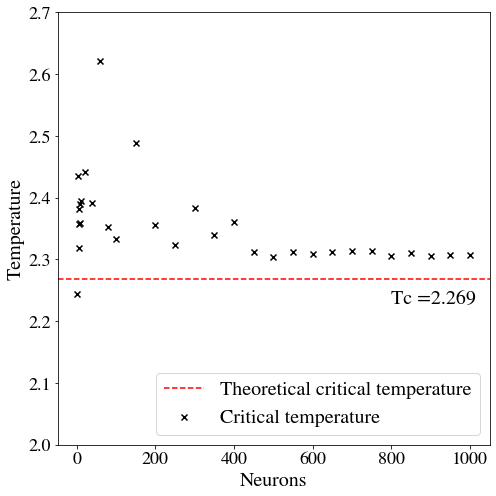

In [40]:
temp = pd.read_csv(os.path.join(resultsfolder, f'critical_temperatures.csv'))

plt.figure(figsize=(7, 7))
plt.scatter(temp['Neurons'][1:],temp['Temperature'][1:], marker='x', color='black', label='Critical temperature')
plt.axhline(y=2.269, color = 'red', linestyle = '--', label = 'Theoretical critical temperature')
plt.xlabel('Neurons')
plt.ylabel('Temperature')

plt.text(800, 2.25, rf'Tc ={2.269}', color='black', 
        verticalalignment='top', horizontalalignment='left', fontsize=20)

plt.ylim((2, 2.7))
plt.legend(loc='lower right')
plt.savefig(os.path.join(os.getcwd(), resultsfolder, 'critical_temperatures.pdf'))
plt.show()

# Finding transition temperature using the Half-height method

Prediction for 1 neurons in hidden layer


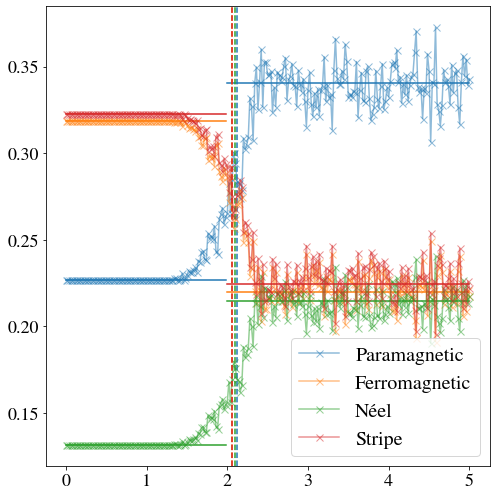

Prediction for 2 neurons in hidden layer


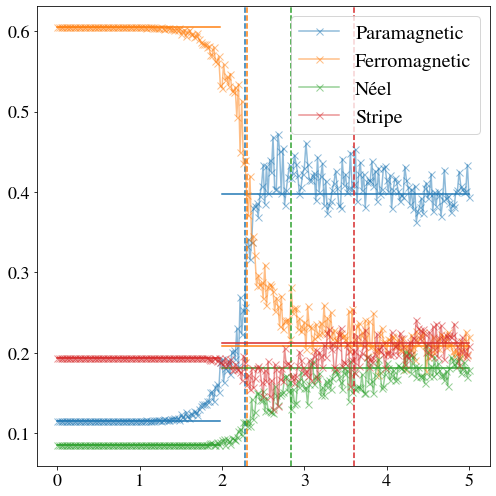

Prediction for 3 neurons in hidden layer


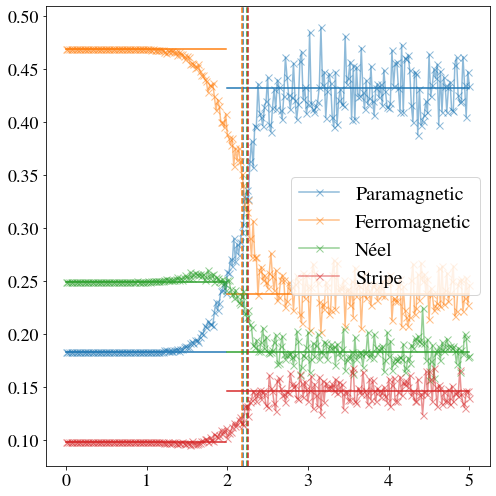

Prediction for 4 neurons in hidden layer


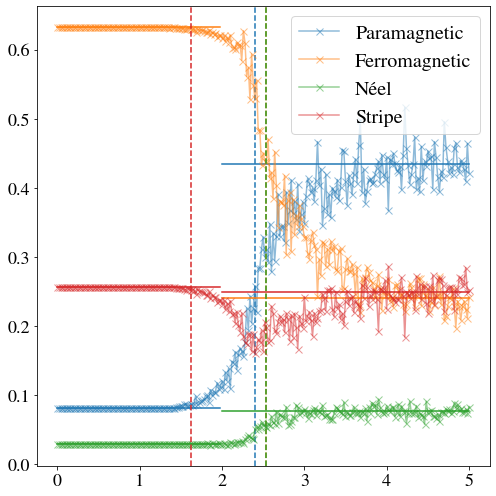

Prediction for 5 neurons in hidden layer


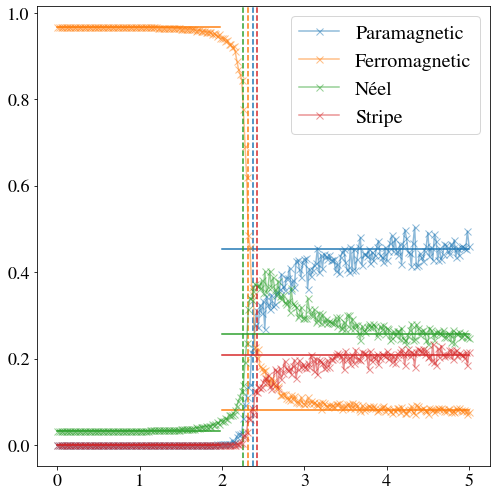

Prediction for 6 neurons in hidden layer


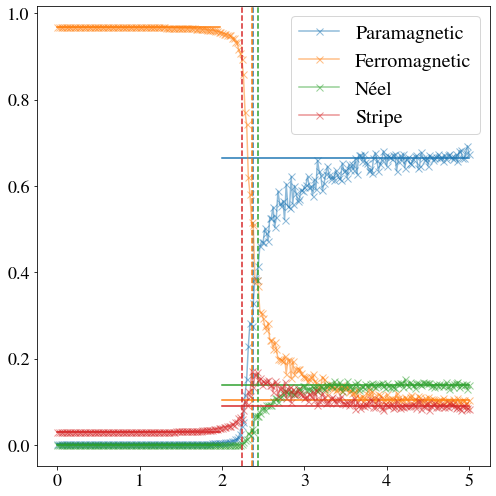

Prediction for 7 neurons in hidden layer


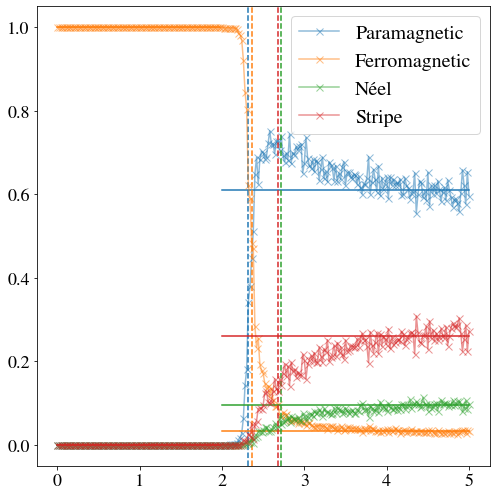

Prediction for 8 neurons in hidden layer


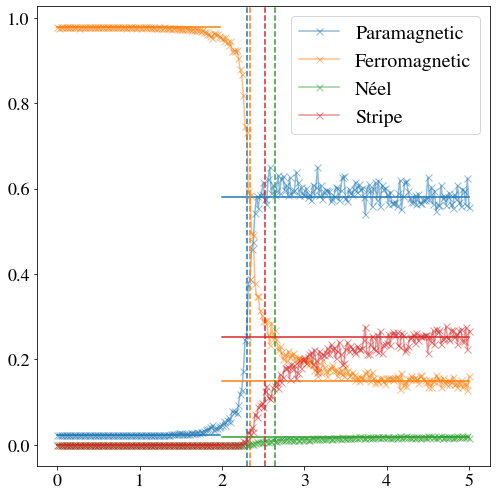

Prediction for 9 neurons in hidden layer


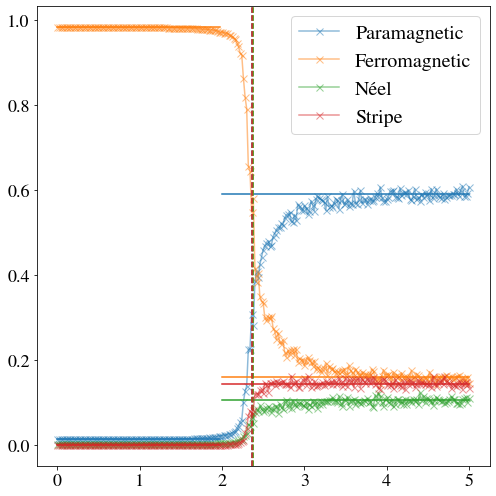

Prediction for 10 neurons in hidden layer


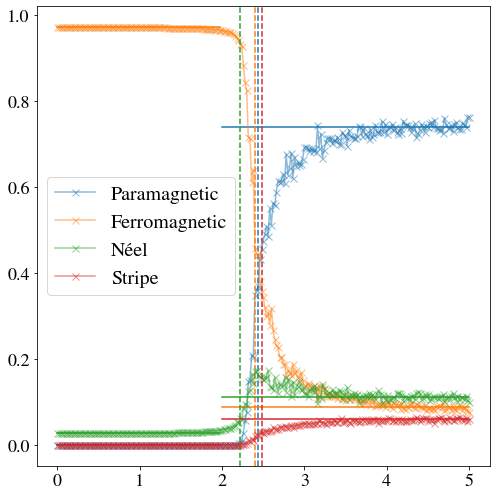

Prediction for 20 neurons in hidden layer


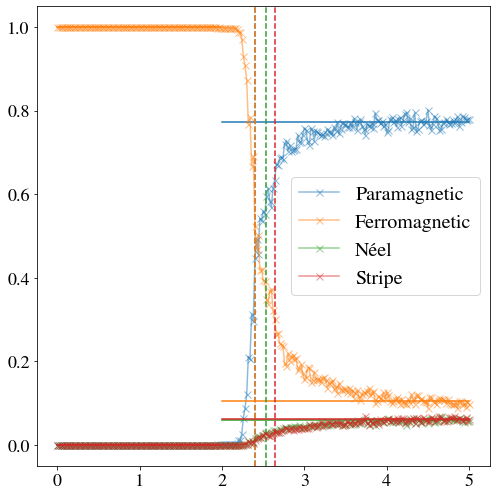

Prediction for 40 neurons in hidden layer


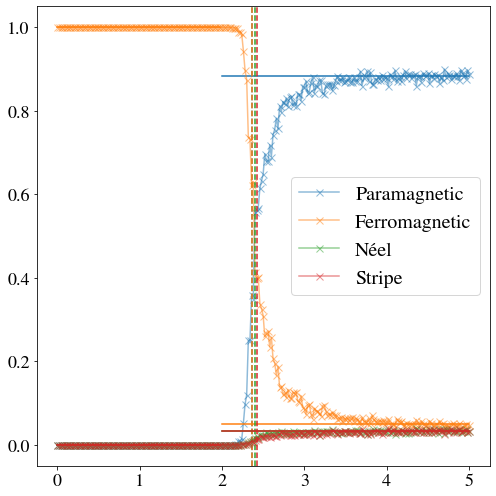

Prediction for 60 neurons in hidden layer


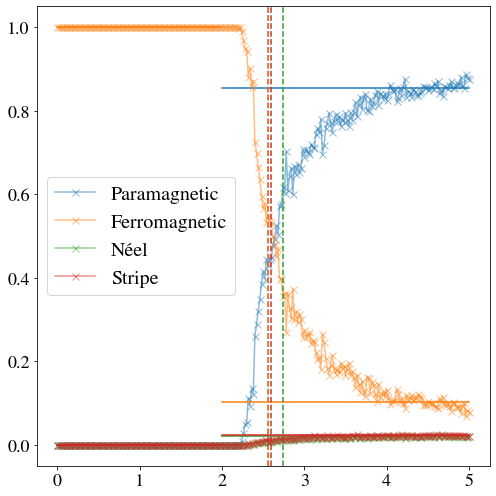

Prediction for 80 neurons in hidden layer


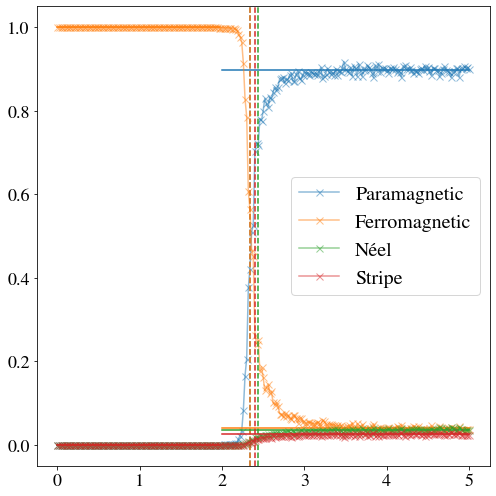

Prediction for 100 neurons in hidden layer


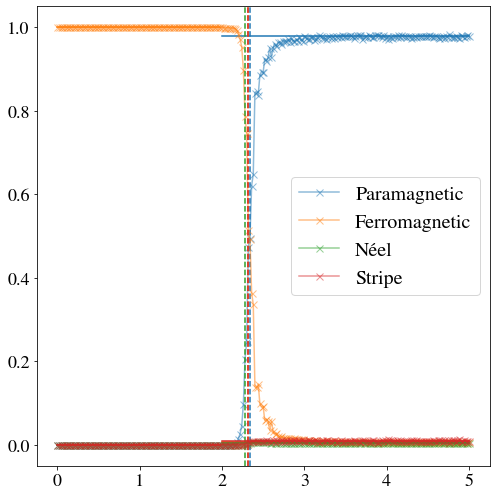

Prediction for 150 neurons in hidden layer


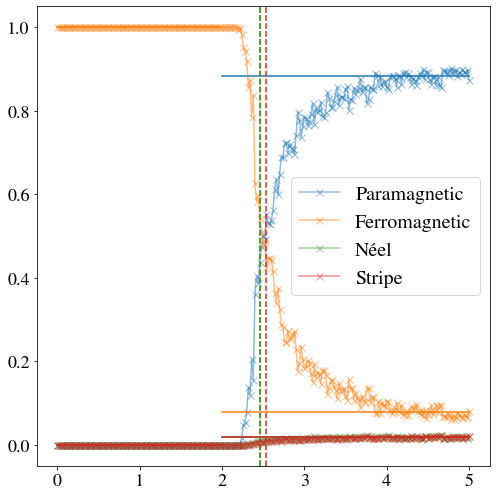

Prediction for 200 neurons in hidden layer


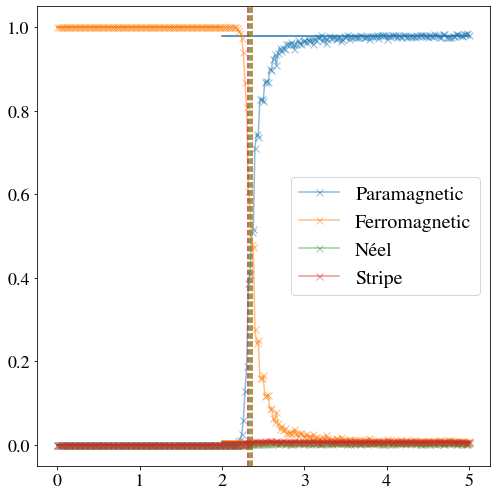

Prediction for 250 neurons in hidden layer


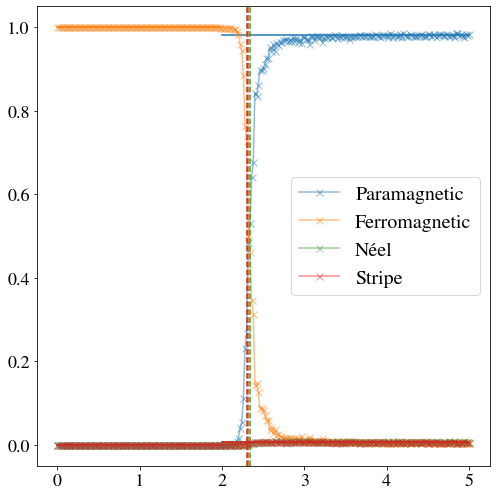

Prediction for 300 neurons in hidden layer


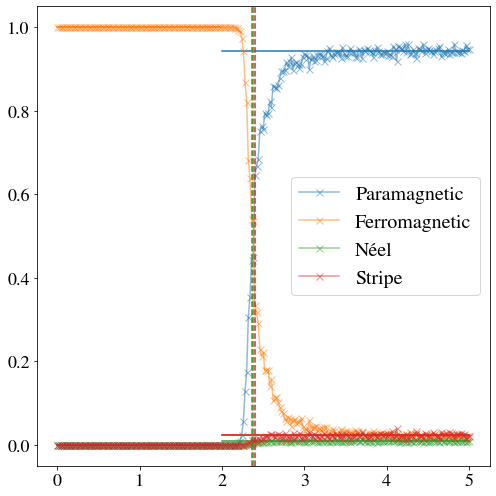

Prediction for 350 neurons in hidden layer


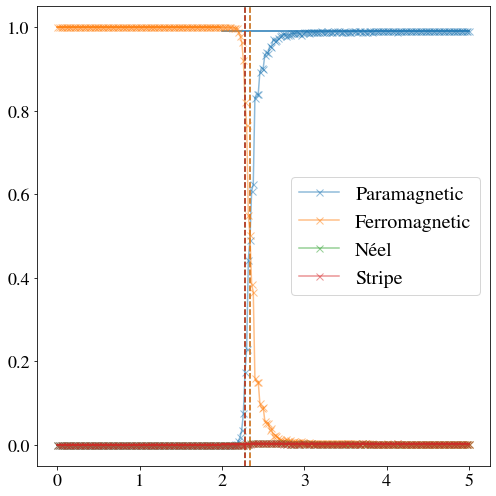

Prediction for 400 neurons in hidden layer


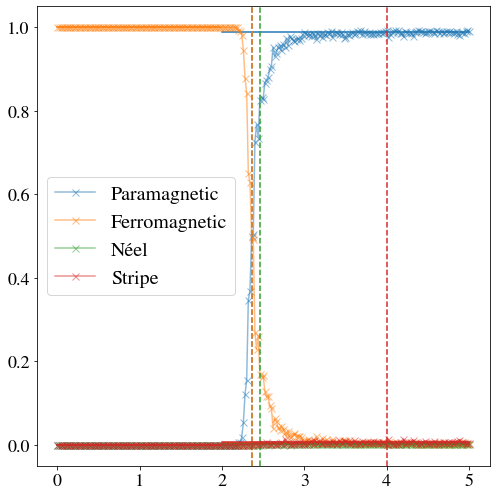

Prediction for 450 neurons in hidden layer


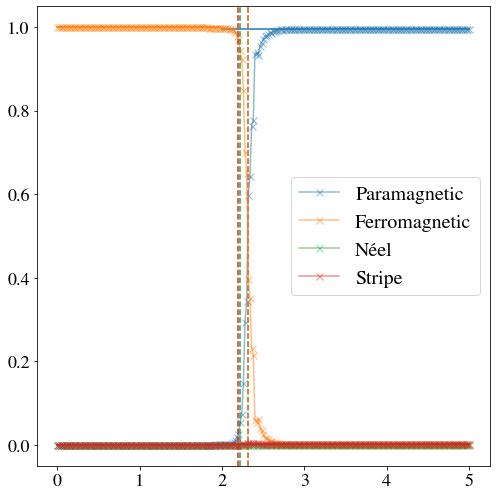

Prediction for 500 neurons in hidden layer


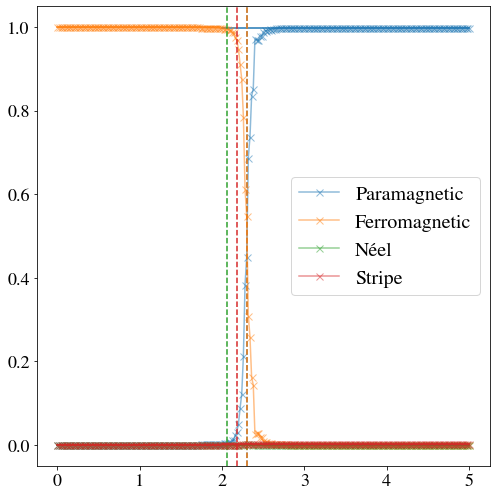

Prediction for 550 neurons in hidden layer


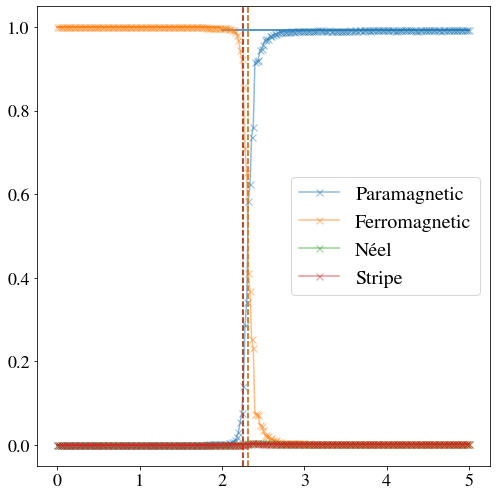

Prediction for 600 neurons in hidden layer


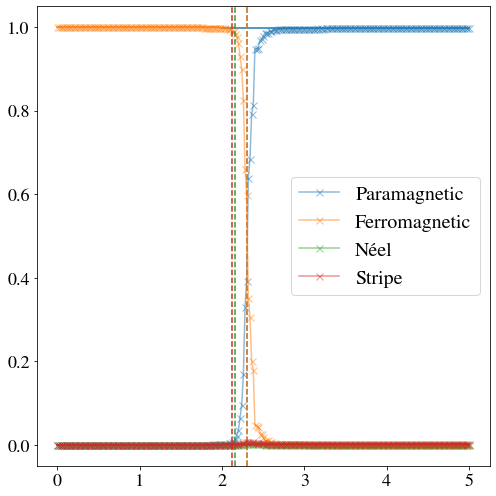

Prediction for 650 neurons in hidden layer


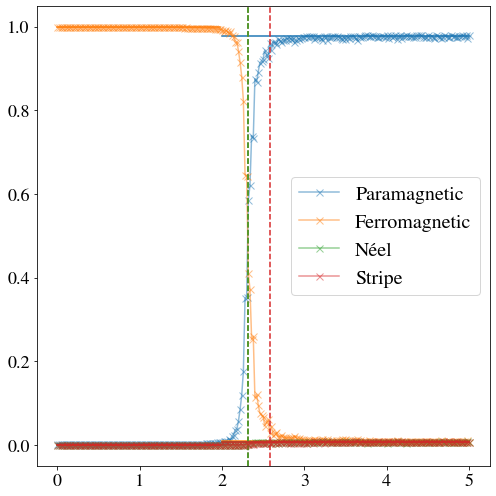

Prediction for 700 neurons in hidden layer


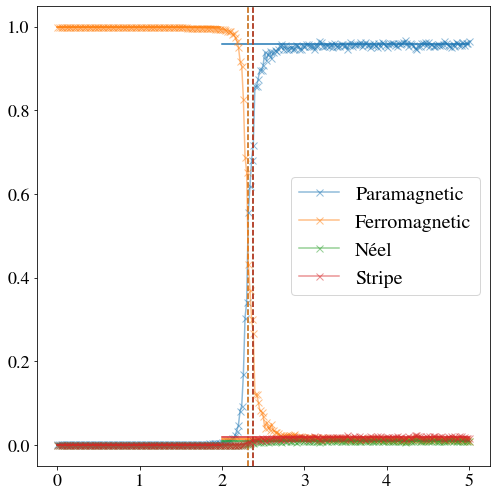

Prediction for 750 neurons in hidden layer


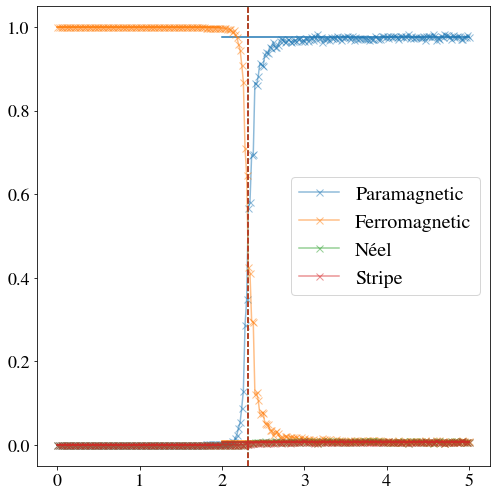

Prediction for 800 neurons in hidden layer


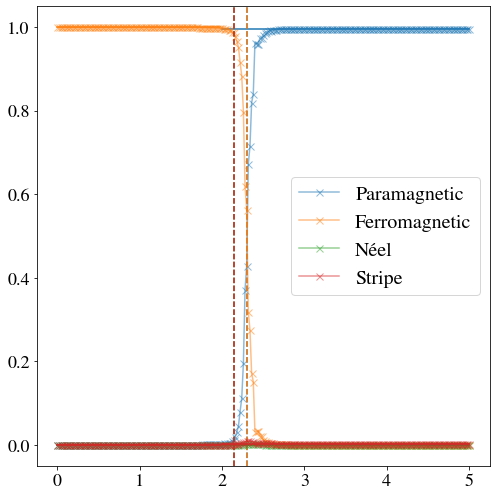

Prediction for 850 neurons in hidden layer


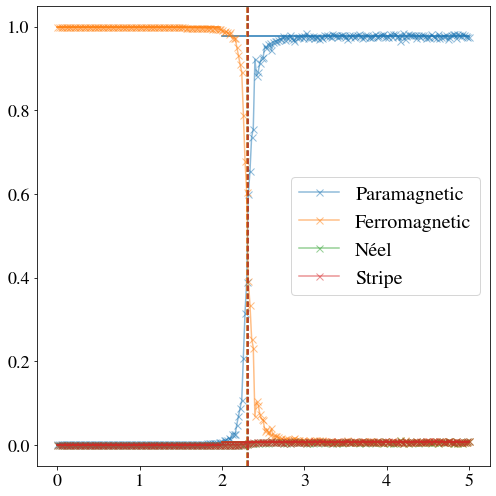

Prediction for 900 neurons in hidden layer


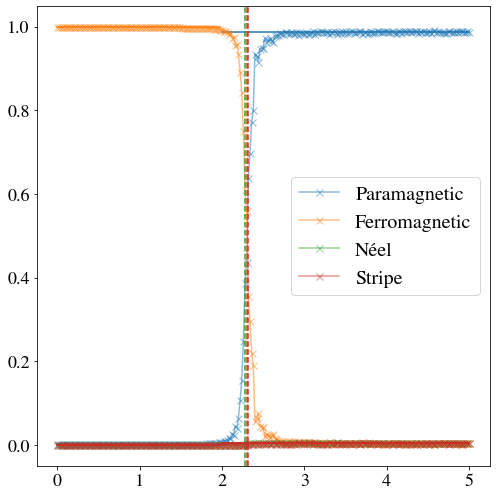

Prediction for 950 neurons in hidden layer


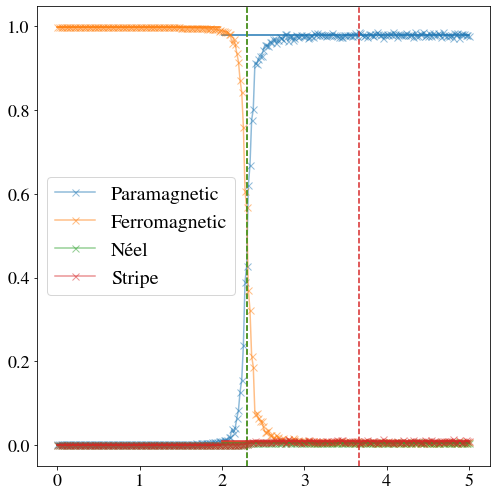

Prediction for 1000 neurons in hidden layer


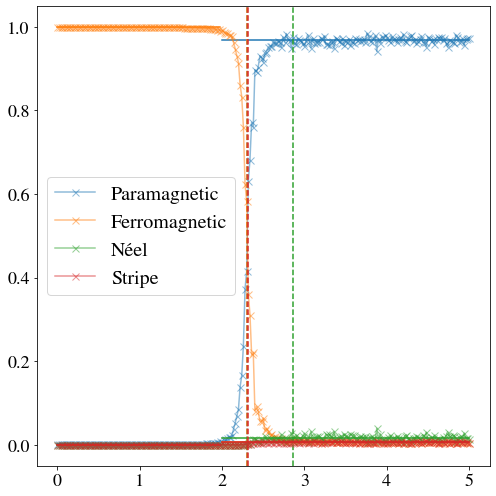

In [4]:
training = ['all']
modelsfolder, resultsfolder = auxLib.folders(directory='2024-08-18', training=training)
saving_folder = os.path.join(os.getcwd(), 'DNN', 'All', 'predictions', datetime.now().strftime('%Y-%m-%d'), 'Half-height')
os.makedirs(saving_folder, exist_ok = True)

critical_temperatures = []

for neuron in neurons:
	print(f'Prediction for {neuron} neurons in hidden layer')
	tc, plot = auxLib.half_height(resultsfolder, name=f'predictions_{neuron}', prediction=None, graph=True)
	plot.savefig(saving_folder+f'/critical_temperature_{neuron}.pdf') #saving the figure
	plot.show()
	critical_temperatures.append(tc)

temp = pd.DataFrame((np.concatenate((np.array(neurons).reshape(len(neurons),1), 
                                    np.array(critical_temperatures).reshape(len(neurons),1)),axis=1)), 
                                    columns=['Neurons','Temperature'])
temp.to_csv(os.path.join(saving_folder, 'critical_temperatures(half).csv'), index=False)

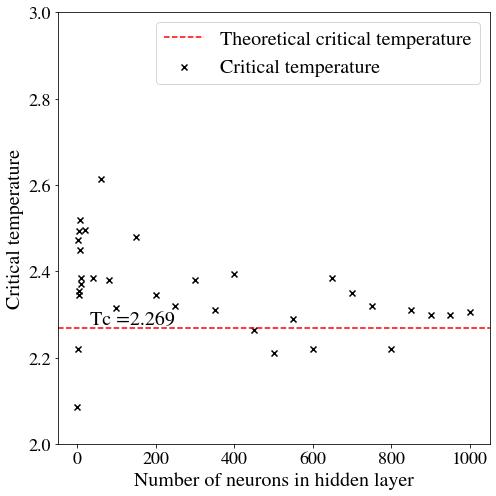

In [5]:
data_df = pd.read_csv(os.path.join(saving_folder,f'critical_temperatures(half).csv'), header=0)

plt.figure(figsize=(7, 7))

plt.scatter(data_df['Neurons'], data_df['Temperature'], marker='x', color='black', label='Critical temperature') # excluding the first neuron
plt.axhline(y=2.269, color = 'red', linestyle = '--', label = 'Theoretical critical temperature')

plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Critical temperature')

plt.text(250, 2.269, rf'Tc ={2.269}', color='black', 
        verticalalignment='bottom', horizontalalignment='right', fontsize=20)

plt.ylim((2, 3))
plt.legend()
plt.savefig(os.path.join(saving_folder, 'critical_temperature(half).pdf'))
plt.show()

# Graphing the predictions of each feature and different number of neurons

In [3]:
# We load the results of predictions of 2024-08-18

training = 'all'

modelsfolder, resultsfolder = auxLib.folders(directory='2024-08-18', training=[training])

saving_folder = os.path.join(os.getcwd(), 'DNN', 'All', 'predictions', datetime.now().strftime('%Y-%m-%d'))

os.makedirs(saving_folder, exist_ok=True)

## For $N=1$ to $N=200$

Feature: para


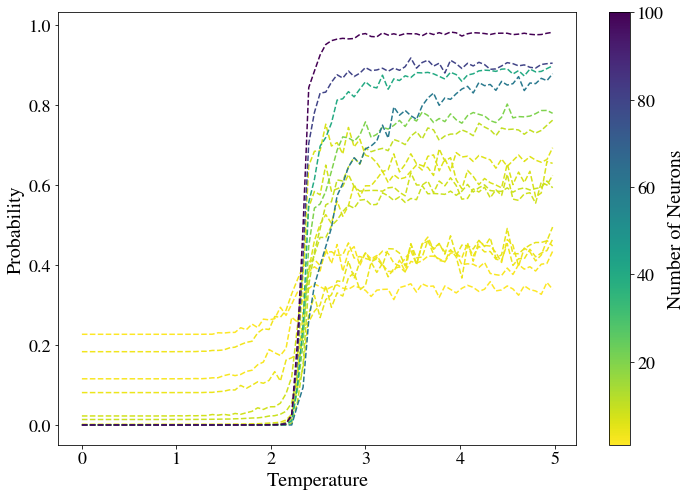

Feature: ferro


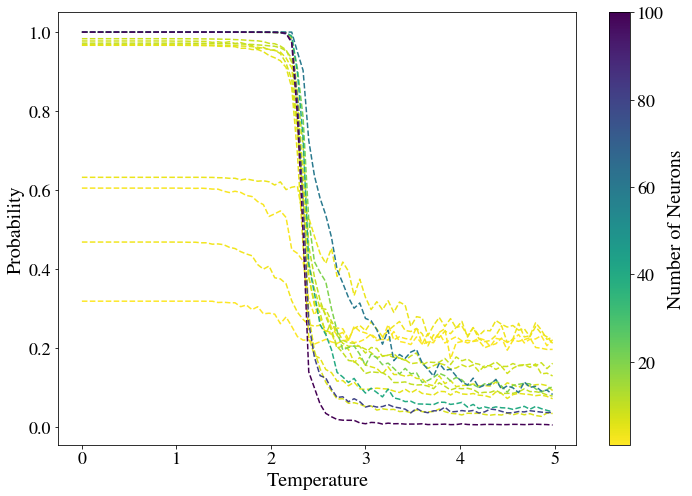

Feature: neel


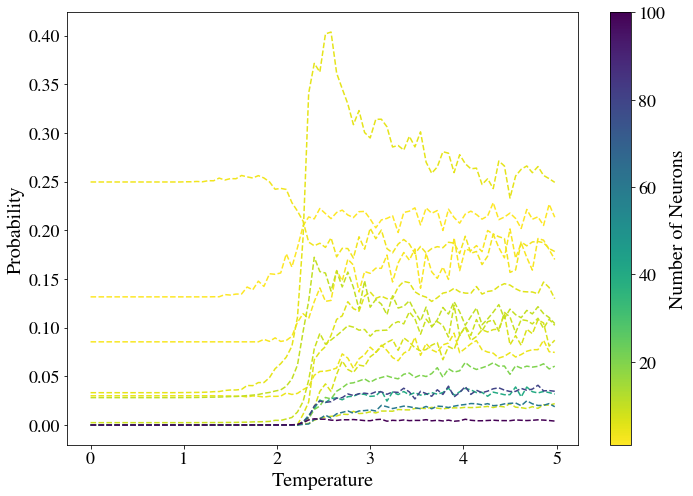

Feature: stripe


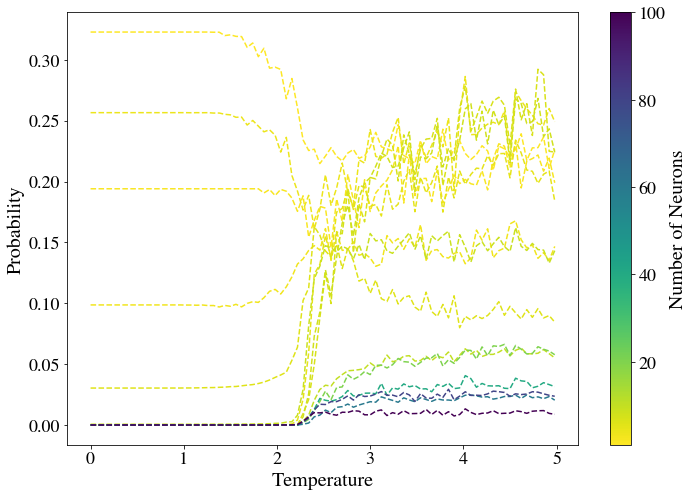

In [47]:
features = ['para', 'ferro', 'neel', 'stripe']

first_neurons = [i for i in range(1, 11)]
middle_neurons = [20 * i for i in range(1, 6)]
last_neurons = [50 * i for i in range(3, 21)]

neurons = first_neurons + middle_neurons 

cmap = plt.get_cmap('viridis_r')#('coolwarm')

norm = plt.Normalize(vmin=1, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

for feature in features:
    print(f'Feature: {feature}')
    plt.figure(figsize=(10, 7))
    index = features.index(feature) + 1
    for neuron in neurons:
        data_np = pd.read_csv(os.path.join(resultsfolder, f'predictions_{neuron}.csv'), header=0).to_numpy(float)
        temperature, para, ferro, neel, stripe = data_np.T
        data = [temperature, para, ferro, neel, stripe]
        alternating_indices = np.arange(0, len(data[0]), 3)
        plt.plot(data[0][alternating_indices], data[index][alternating_indices], '--', color=cmap(norm(neuron)))
    plt.xlabel('Temperature')
    plt.ylabel('Probability')
    
    # Add the colorbar
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    cbar.set_label('Number of Neurons')
    
    plt.savefig(os.path.join(saving_folder, f'{feature}_all_neurons(N=1-100).pdf'))
    plt.show()


## For $N=150$ to $N=1000$

Feature: para


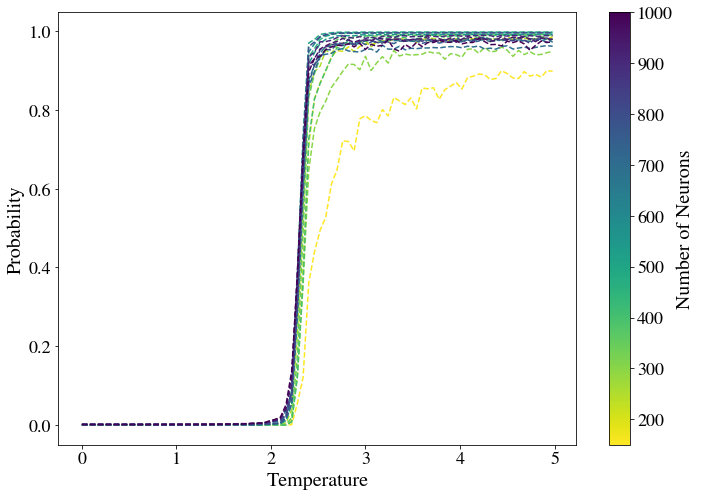

Feature: ferro


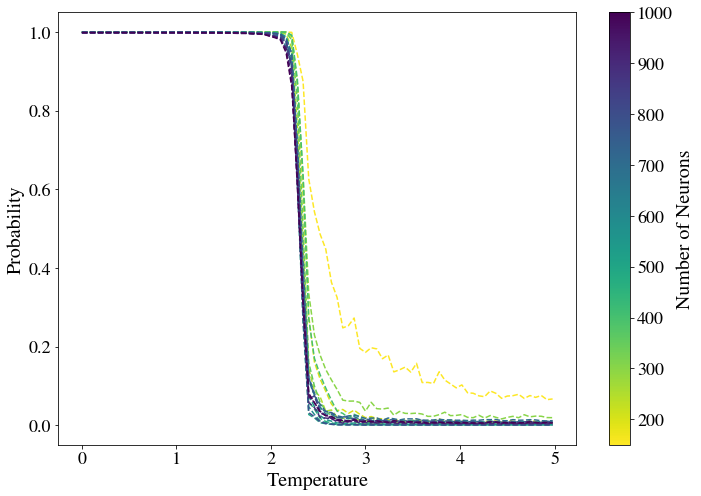

Feature: neel


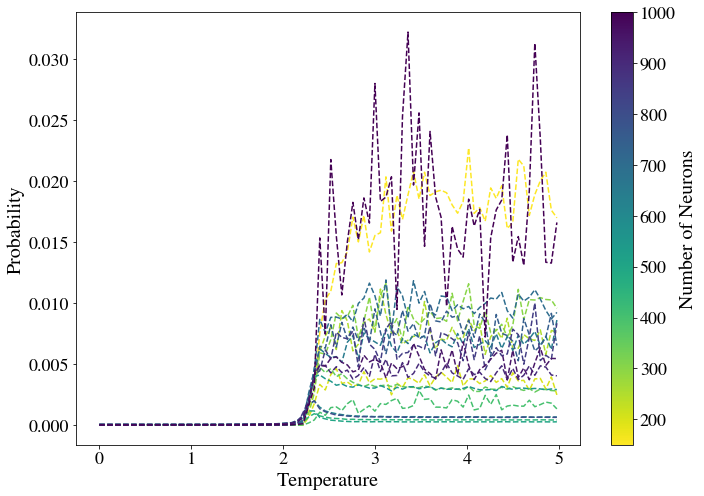

Feature: stripe


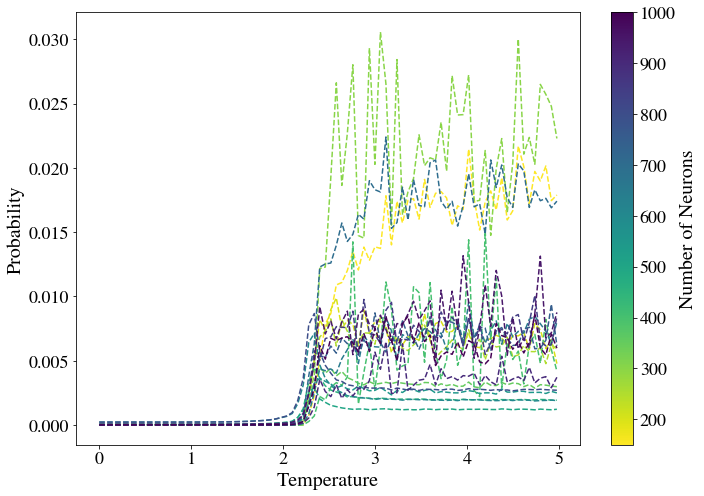

In [46]:
features = ['para', 'ferro', 'neel', 'stripe']

first_neurons = [i for i in range(1, 11)]
middle_neurons = [20 * i for i in range(1, 6)]
last_neurons = [50 * i for i in range(3, 21)]

neurons = last_neurons 

cmap = plt.get_cmap('viridis_r')#('coolwarm')

norm = plt.Normalize(vmin=150, vmax=1000)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

for feature in features:
    print(f'Feature: {feature}')
    plt.figure(figsize=(10, 7))
    index = features.index(feature) + 1
    for neuron in neurons:
        data_np = pd.read_csv(os.path.join(resultsfolder, f'predictions_{neuron}.csv'), header=0).to_numpy(float)
        temperature, para, ferro, neel, stripe = data_np.T
        data = [temperature, para, ferro, neel, stripe]
        alternating_indices = np.arange(0, len(data[0]), 3)
        plt.plot(data[0][alternating_indices], data[index][alternating_indices], '--', color=cmap(norm(neuron)))
    plt.xlabel('Temperature')
    plt.ylabel('Probability')
    
    # Add the colorbar
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
    cbar.set_label('Number of Neurons')
    
    plt.savefig(os.path.join(saving_folder, f'{feature}_all_neurons(N=150-1000).pdf'))
    plt.show()